#NASA Space Apps Challenge 2023 in Tashkent



### Team: Typhoon
### Members:
- Yaxshiliqov Javlon
- Jabborov Diyorbek

In [1]:
import os
import sys
import glob
import numpy as np
import keras
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors

from config import common_config, dataset_config, training_config, model_config, test_config, classification_config
import model_resunet

In [ ]:
# Parameters

output_predictions_dir = os.path.join(common_config["OUTPUT_DIR"], "predictions")
if not os.path.exists(output_predictions_dir):
    os.makedirs(output_predictions_dir)


model_pattern =  "/content/fire_model_crisp-microwave-181_weights.h5"

In [ ]:
# Look for a model
model_paths = glob.glob(model_pattern)
if not len(model_paths) == 1:
    print("One model must be provided.")
    sys.exit()

# Define ResUNet model
model = model_resunet.get_model([model_config["IMG_SIZE"][0],model_config["IMG_SIZE"][1],len(dataset_config["INPUT_FEATURES"])])

# Load model weights
model.load_weights(os.path.join(model_paths[0]))

In [ ]:
# Read input .npy files and get them ready for classification. Also read target output for visualisation.
input_data = []
targets = []

for sample_id in classification_config["SAMPLE_IDS"]:
    sample_dir = "/content/"
    input_filenames = list()
    for input_feature_name in dataset_config["INPUT_FEATURES"]:
        found_fname = glob.glob(sample_dir+'/{}*.npy'.format(input_feature_name))
        input_filenames.append(found_fname[0])
    combined_data = np.array([np.load(fname) for fname in input_filenames])
    input_data.append(combined_data)

    output_filenames = list()
    for target_feature_name in dataset_config["OUTPUT_FEATURES"]:
        found_fname = glob.glob(sample_dir+'/{}*.npy'.format(target_feature_name))
        output_filenames.append(found_fname[0])
    target_array = np.array([np.load(fname) for fname in output_filenames])
    targets.append(target_array)

input_data = np.moveaxis(np.array(input_data), 1, -1)
targets = np.moveaxis(np.array(targets), 1, -1)

In [ ]:
# Clip and rescale values according to dataset stats.
for i, input_feature_name in enumerate(dataset_config["INPUT_FEATURES"]):
    min_val, max_val, _, _ = dataset_config["DATA_STATS"][input_feature_name]
    input_data[:, :, :, i] = np.clip(input_data[:, :, :, i], min_val, max_val)

    if not input_feature_name in dataset_config["FEATURES_NOT_NORM"]:
        input_data[:, :, :, i] = np.divide((input_data[:, :, :, i]-min_val), (max_val - min_val), out=np.zeros_like(input_data[:, :, :, i]), where=(max_val - min_val)!=0)

In [ ]:
# Predict
preds = list()
for input_sample in input_data:
    input_sample = np.expand_dims(input_sample, axis=0)
    pred = model.predict(input_sample)
    preds.append(pred)
preds = np.array(preds).squeeze(axis=1)
masks = np.round(preds)

1/1 [==============================] - 1s 564ms/step


In [ ]:
# Save predictions (classification and probabilities) as .npy files.
for sample_id, mask, pred in zip(classification_config["SAMPLE_IDS"], masks, preds):
    classif_output_dir = os.path.join(output_predictions_dir, str(sample_id))
    if not os.path.exists(classif_output_dir):
        os.makedirs(classif_output_dir)
    classification_filepath = os.path.join(classif_output_dir, "classification")
    probabilities_filepath = os.path.join(classif_output_dir, "probabilities")
    np.save(classification_filepath, mask)
    np.save(probabilities_filepath, pred)

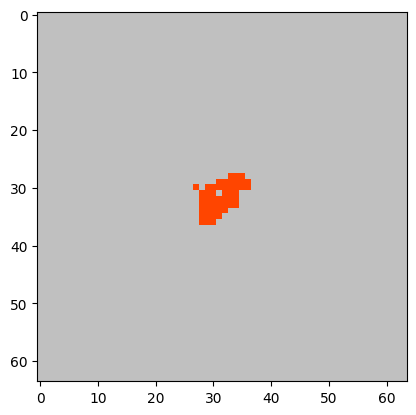

In [ ]:
# Visualize outputs, target output, previous day fire mask.
CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

img_ind = 0

plt.imshow(input_data[img_ind, :, :, -1], cmap=CMAP, norm=NORM)

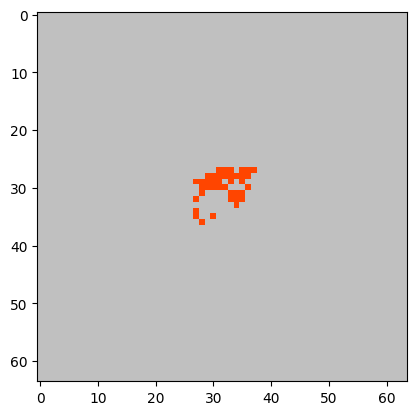

In [ ]:
plt.imshow(targets[img_ind, :, :, 0], cmap=CMAP, norm=NORM)

In [ ]:
plt.imshow(masks[img_ind, :, :], cmap=CMAP, norm=NORM)

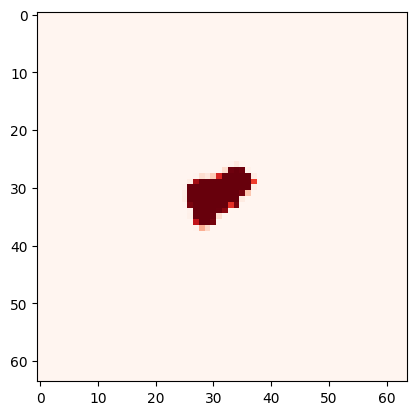

In [ ]:
plt.imshow(preds[img_ind, :, :], cmap='Reds')

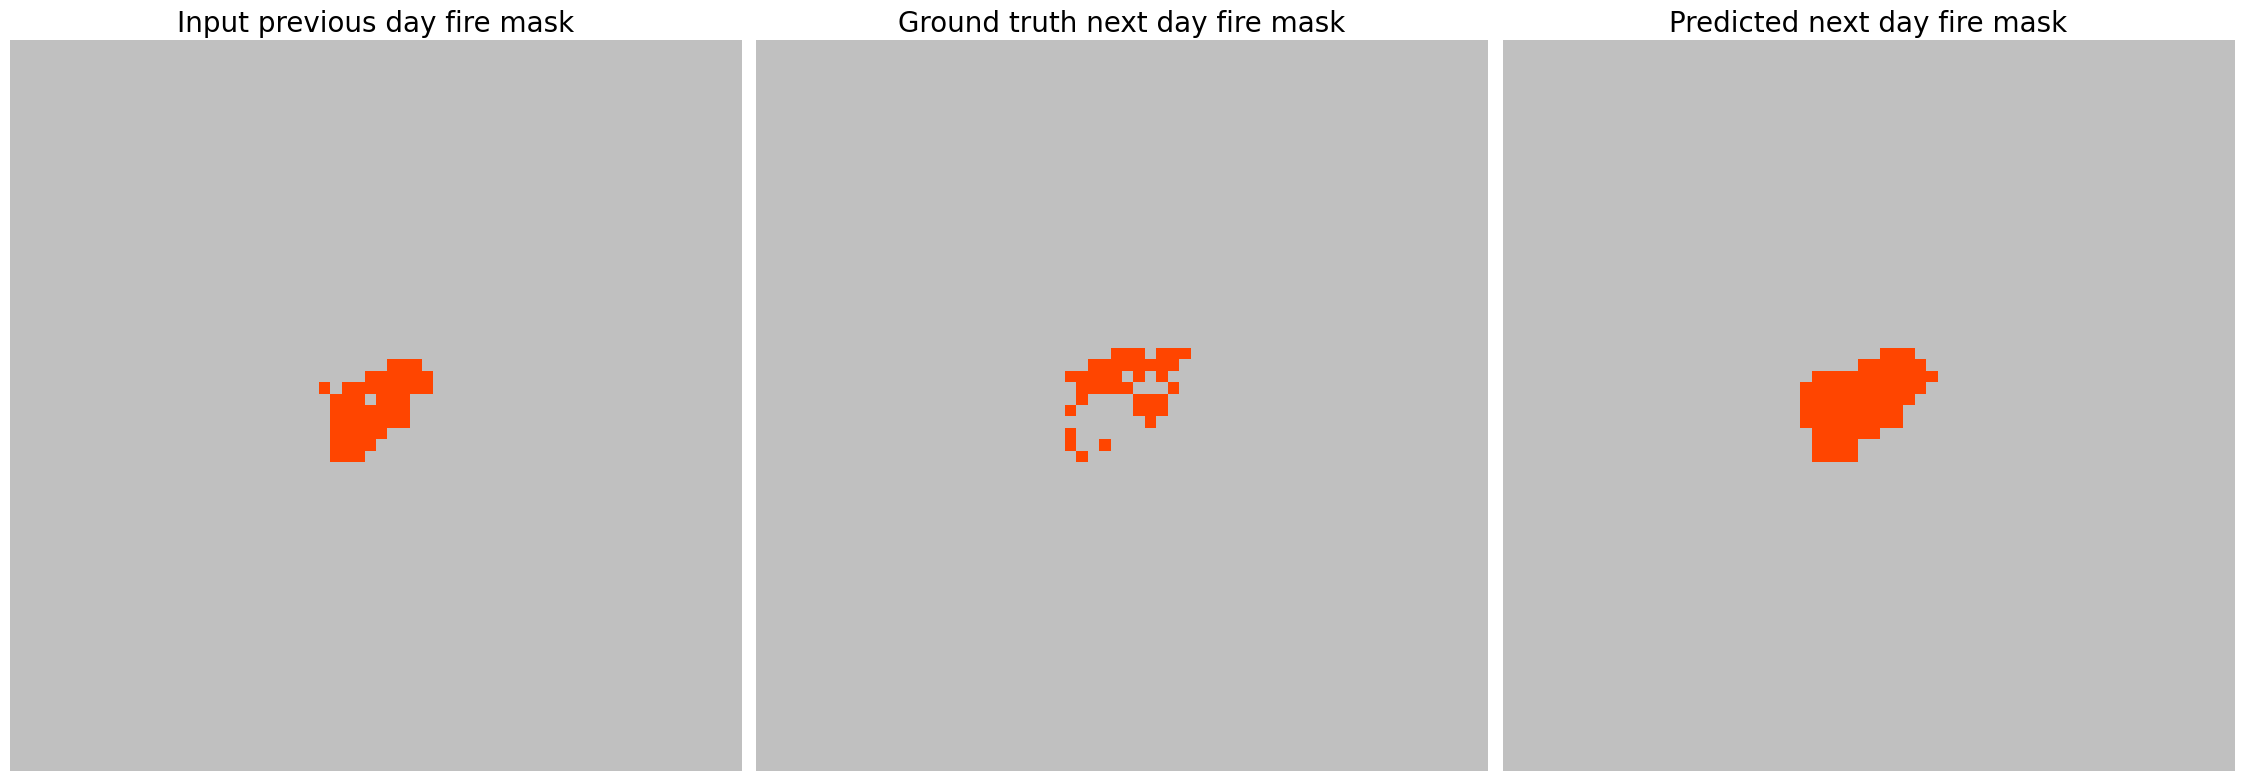

In [ ]:
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 1
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(30,13))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=20)
        if j == 0:
            plt.imshow(input_data[i, :, :, -1], cmap=CMAP, norm=NORM)
        if j == 1:
            plt.imshow(targets[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')
plt.tight_layout()